<a href="https://colab.research.google.com/github/andrewcgaitskell/celldb/blob/master/DataPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [30]:
import pandas as pd
import numpy as np

In [31]:
import os
dirname = os.getcwd()
print(dirname)

/home/jupyterlab/pipeline-202102


In [32]:
os.environ['MPLCONFIGDIR'] = dirname
import matplotlib

In [33]:
#!pip install xlsxwriter
#!pip install xlrd
#!pip install matplotlib
import xlsxwriter
import xlrd

from google.colab import drive
drive.mount('/content/drive')

# Introduction

In [34]:
from datetime import datetime

In [35]:
from datetime import datetime
my_date = datetime.now()
print(my_date.isoformat())

2021-02-08T11:56:41.196315


In [36]:
print(my_date.strftime('%Y-%m-%dT%H:%M:%S.%f%z'))

2021-02-08T11:56:41.196315


In [37]:
runid = "R" + my_date.strftime('%Y%m%d%H%M%S%f%z')
runid

'R20210208115641196315'

In [38]:
dirname = os.getcwd()
print(dirname)

/home/jupyterlab/pipeline-202102


## Upload File

# Excel Data Types

The following functions are use to work out the data type of an excel cell.

In [39]:
def validate_date(date_text):
    try:
        format_string = '%Y-%m-%d %H:%M:%S'
        datetime.strptime(date_text, format_string)
        return "OK"
    except ValueError:
        return None

def GetDataType(row_in):
    valueasstring = str(row_in['CellValue'])
    if validate_date(valueasstring) != None:
        return 'Date'
    elif valueasstring.isnumeric():
        return 'Number'
    else:
        return 'Text'

def add1_2row(row_in):
    return row_in['RowID'] + 1


def add1_2column(row_in):
    return row_in['ColumnID'] + 1

In [40]:
#from ipywidgets import FileUpload
#upload = FileUpload()
#upload

In [41]:
#import io
#filedf = pd.read_excel(upload.data[0],sheet_name=None, header=None, encoding='utf-8', errors='ignore')
#filedf = pd.read_excel(upload.data[0],sheet_name=None, header=None)
filename = dirname + '/Data.xlsx'
filedf = pd.read_excel(filename,engine='openpyxl', sheet_name=None, header=None)
#/content/drive/MyDrive/Work/Data/Data.xlsx

In [42]:
#filedf

# Read All Sheets into Data Frame

In [43]:
sheetnames = list(filedf.keys())

In [44]:
print(sheetnames)

['AgeGenderSheet', 'HomeSheet', 'JobSheet', 'MaritalDepartmentSheet', 'DataMap', 'TemplateValidationMap', 'DataSet', 'Rules', 'Palette', 'PickList']


Each Sheet is retrieved into Dataframes

DataMapDF = specdf['DataMap']
TemplateValidationMapDF = specdf['TemplateValidationMap']
DataSetDF = specdf['DataSet']
RulesDF = specdf['Rules']
PaletteDF = specdf['Palette']
PickListDF = specdf['PickList']
datadf = pd.DataFrame()


The following converts the whole spreadsheet into a cell database and this is used throughout for all data frame population.

In [45]:
celldbstagedf = pd.DataFrame()
sheetdf = filedf['DataMap'].copy()
sheetdf["RowID"] = sheetdf.index
#sheetdf

In [46]:
for currentsheetname in sheetnames:

    sheetdf = filedf[currentsheetname].copy()
    sheetdf["RowID"] = sheetdf.index
    celldb = pd.melt(sheetdf, id_vars=['RowID'])
    celldb = celldb.rename(columns={"variable": "ColumnID", "value": "CellValue"})
    celldb["CellType"] = "Unset"
    celldb["FileName"] = runid
    celldb["SheetName"] = currentsheetname
    
    celldb["ColumnID"] = celldb["ColumnID"]

    try:
        celldb["CellType"] = celldb.apply(GetDataType, axis=1)
        celldb["RowID"] = celldb.apply(add1_2row, axis=1)
        celldb["ColumnID"] = celldb.apply(add1_2column, axis=1)

    except:

        celldb["CellType"] = 'unknown'
        celldb["RowID"] = 0
        celldb["ColumnID"] = 0

    celldbstagedf = celldbstagedf.append(celldb, ignore_index=True)

    celldb = pd.DataFrame()



In [47]:
fullcelldb = celldbstagedf.copy()

In [48]:
#df = celldbstagedf[celldbstagedf['SheetName']=='AgeGenderSheet']
parametersheets = ['DataMap', 'TemplateValidationMap', 'DataSet', 'Rules', 'Palette', 'PickList']
DatasetCells = fullcelldb[~fullcelldb.SheetName.isin(parametersheets)]
#DatasetCells

#df[~df.country.isin(countries_to_keep)]

# Get Picklist Values

Picklist are like a mini Master Data Management System

They define the acceptable values for a partcular Field in Excel

The challenge here was to check one column to a another column that contained a list.  I go there in the end.

In [49]:
PickListCells = pd.DataFrame()
# This process uses the full cell database as the column headings are the Picklist Names
PickListCells = fullcelldb[(fullcelldb['SheetName'] == 'PickList')].copy()
# PickListCellsList = PickListCells.groupby('ColumnID')['CellValue'].apply(lambda group_series: group_series.tolist()).reset_index()

PickListCellsList = PickListCells.groupby('ColumnID').agg({'CellValue':lambda x: list(x)})

# these were odd, but glad I work them out, it is important to realise that these are operations on a number of rows, not just one
# maybe it was the axis that made the difference!
PickListCellsList['KeyWord'] = PickListCellsList.apply(lambda row : row['CellValue'][0], axis = 1)
PickListCellsList['FormulaKeyWord'] = PickListCellsList.apply(lambda row : 'PickList', axis = 1)
PickListCellsList['List'] = PickListCellsList.apply(lambda row : row['CellValue'][1:], axis = 1)
# PickListCellsList['KeyWord'] = PickListCellsList['CellValue']
#PickListCellsList= pd.DataFrame(PickListCellsList, columns=['KeyWord', 'List'])
PickListCellsList = pd.DataFrame(PickListCellsList, columns=['KeyWord', 'FormulaKeyWord', 'List'])
#PickListCellsList.head()

In [50]:
# These were attempts at creating a suitable list for the function to check to

# PickListCellsList['Result'] = PickListCellsList['KeyWord'].isin(PickListCellsList['List']).map({True: 0, False: 1})

# PickListCellsList['Result'] = PickListCellsList['KeyWord'].str.contains('|'.join(PickListCellsList['List']))
# PickListCellsList['Result'] = PickListCellsList['KeyWord'].str.contains('|'.join(x) for x in PickListCellsList['List'])
# ["".join(x) for x in lst]
# PickListCellsList['ListAsString'] = PickListCellsList['List'].str.join('-')
# PickListCellsList['ListAsTuple'] = tuple(PickListCellsList['CellValue'])


In [51]:
#MyList = pd.DataFrame()
#MyList =  PickListCellsList
# still do not know why the following DOES NOT WORK!
# MyList['Result'] = PickListCellsList['ListAsString'].isin(PickListCellsList['KeyWord'])

# leaving this as a rememberance of the 6 hours spent on this!
# MyList['Result1'] = PickListCellsList['KeyWord'].apply(lambda x: any(i in x for i in PickListCellsList['List']))
# MyList['Result2'] = PickListCellsList['ListAsString'].str.contains(PickListCellsList['KeyWord'])
# mask = df['A'].apply(lambda x: any(i in x for i in search_list))
# PickListCellsList['Result2'] = PickListCellsList['ListAsTuple'].str.contains(PickListCellsList['KeyWord'])
# PickListCellsList['Result2'] = PickListCellsList['KeyWord'].str.contains(tuple(PickListCellsList['List']))
# PickListCellsList['ListAsTuple'].isin(PickListCellsList['KeyWord'])
# MyList['Result2'] = PickListCellsList['List'].apply(lambda x: True if (PickListCellsList.KeyWord in x).any() else False)
######### MyList['sing'] = 'Single'
# MyList['res1'] = MyList.apply(lambda ts: any(ts == 'Single'), axis=1)
# MyList['res2'] = MyList.apply(lambda ts: MyList['KeyWord'].str.contains('Single'), axis=1)
######### MyList['res3'] = MyList.apply(lambda x: x['sing'] in x['ListAsTuple'], axis=1)  ###############
######### MyList['res4'] = MyList.apply(lambda x: x['sing'] in x['List'], axis=1).map({True: 1, False: 0}) ###############
# # # # dataset.apply(lambda x: x['CellValue'] in x['PickList'], axis=1).map({True: 1, False: 0})
# data['Activity].str.contains('skin diving')
# lambda x : True if (x > 10 and x < 20) else False
#MyList.head()
# https://stackoverflow.com/questions/48460234/pandas-apply-valueerror-the-truth-value-of-a-series-is-ambigous

# Get Data Map

In [52]:
DataMapCells = pd.DataFrame()
DataMapCells = fullcelldb[(fullcelldb['SheetName'] == 'DataMap')].copy()
#DataMapCells.head()

Below extracts a Sheet from the cell database and reshapes it to it original tabular form.

In [53]:
DataMap = pd.DataFrame()
DataMap = DataMapCells.pivot_table(index = ['RowID'], values = 'CellValue',columns = 'ColumnID', aggfunc = 'max')
ColumnHeadings = DataMap.iloc[0]
ColumnHeadingsList = list(ColumnHeadings)
print(ColumnHeadingsList)
ColumnHeadingsListTuple = enumerate(ColumnHeadingsList,start=1)
ColumnHeadingsListDict = dict(ColumnHeadingsListTuple)
print(ColumnHeadingsListDict)
DataMap = DataMap.rename(columns=ColumnHeadingsListDict)
DataMap = DataMap.drop([1])
#DataMap.head()

['SheetName', 'ReferenceText', 'RowFromReferenceText', 'ColumnFromReferenceText', 'TemplateText', 'DataGroup', 'DataCategory', 'DataScope', 'Column Header', 'Dataset']
{1: 'SheetName', 2: 'ReferenceText', 3: 'RowFromReferenceText', 4: 'ColumnFromReferenceText', 5: 'TemplateText', 6: 'DataGroup', 7: 'DataCategory', 8: 'DataScope', 9: 'Column Header', 10: 'Dataset'}


# Make Rules Database

In [54]:
RulesCells = pd.DataFrame()
RulesCells = fullcelldb[(fullcelldb['SheetName'] == 'Rules')].copy()
#RulesCells.head()

In [55]:
RulesMatrix = pd.DataFrame()
RulesMatrix = RulesCells.pivot_table(index = ['RowID'], values = 'CellValue',columns = 'ColumnID', aggfunc = 'max')
ColumnHeadings = RulesMatrix.iloc[0]
ColumnHeadingsList = list(ColumnHeadings)
print(ColumnHeadingsList)
ColumnHeadingsListTuple = enumerate(ColumnHeadingsList,start=1)
ColumnHeadingsListDict = dict(ColumnHeadingsListTuple)
print(ColumnHeadingsListDict)
RulesMatrix = RulesMatrix.rename(columns=ColumnHeadingsListDict)
RulesMatrix = RulesMatrix.drop([1])
RulesMatrix.head()

['RuleID', 'DataSet', 'FieldID', 'DataType', 'Format', 'RangeFrom', 'RangeTo', 'Null', 'Length', 'PickList', 'Rule1', 'Rule2', 'Rule3']
{1: 'RuleID', 2: 'DataSet', 3: 'FieldID', 4: 'DataType', 5: 'Format', 6: 'RangeFrom', 7: 'RangeTo', 8: 'Null', 9: 'Length', 10: 'PickList', 11: 'Rule1', 12: 'Rule2', 13: 'Rule3'}


ColumnID,RuleID,DataSet,FieldID,DataType,Format,RangeFrom,RangeTo,Null,Length,PickList,Rule1,Rule2,Rule3
RowID,,,,,,,,,,,,,
2,1,Ages,Name,Text,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
3,2,Ages,Age,Number,NaN,NaN,NaN,N,NaN,NaN,Positive,GreaterThanTen,NaN
4,3,Genders,Name,Text,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
5,4,Genders,Gender,Text,NaN,NaN,NaN,N,NaN,Gender,NaN,NaN,NaN
6,5,DoB,Name,Text,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN


In [56]:
RulesMatrix.head()

ColumnID,RuleID,DataSet,FieldID,DataType,Format,RangeFrom,RangeTo,Null,Length,PickList,Rule1,Rule2,Rule3
RowID,,,,,,,,,,,,,
2,1,Ages,Name,Text,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
3,2,Ages,Age,Number,NaN,NaN,NaN,N,NaN,NaN,Positive,GreaterThanTen,NaN
4,3,Genders,Name,Text,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
5,4,Genders,Gender,Text,NaN,NaN,NaN,N,NaN,Gender,NaN,NaN,NaN
6,5,DoB,Name,Text,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN


The above is the Rules definition sheet. It used KeyWords to define the checks.  Below forms a list of KeyWords that are relevant to a particular field in a DataSet

In [57]:
Rules2Apply = pd.DataFrame()
Rules2Apply = pd.melt(RulesMatrix, id_vars=['RuleID', 'DataSet', 'FieldID'])
Rules2Apply

,RuleID,DataSet,FieldID,ColumnID,value
0,1,Ages,Name,DataType,Text
1,2,Ages,Age,DataType,Number
2,3,Genders,Name,DataType,Text
3,4,Genders,Gender,DataType,Text
4,5,DoB,Name,DataType,Text
...,...,...,...,...,...
145,11,Jobs,Job_Title,Rule3,NaN
146,12,Jobs,Employee_Name,Rule3,NaN
147,13,Jobs,ID,Rule3,NaN
148,14,HomeLocation,Employee,Rule3,NaN


In [58]:
Rules2Apply.value.unique()

array(['Text', 'Number', 'Date', nan, 'N', 'Gender', 'MaritalStatus',
       'HomeLocation', 'Positive', 'GreaterThanTen'], dtype=object)

In [59]:
Rules2Apply = Rules2Apply.rename(columns={"ColumnID": "RuleType", "value": "KeyWord"})
Rules2Apply = Rules2Apply[Rules2Apply.KeyWord.notnull()]
Rules2Apply.KeyWord.unique()

array(['Text', 'Number', 'Date', 'N', 'Gender', 'MaritalStatus',
       'HomeLocation', 'Positive', 'GreaterThanTen'], dtype=object)

In [60]:
# df['A'] = df.apply(lambda x: x['B'] if x['A']==0 else x['A'], axis=1)
# The following adds the KeyWord Null into the Rules list - if Null is N, this means Nulls are Not Allowed
Rules2Apply['KeyWord'] = Rules2Apply.apply(lambda x: x['RuleType'] if x['KeyWord']=='N' else x['KeyWord'], axis=1)
#Rules2Apply['New'] = Rules2Apply.apply(lambda x: x['RuleType'] if x['KeyWord']=='N' else x['KeyWord'], axis=1)
Rules2Apply.KeyWord.unique()

array(['Text', 'Number', 'Date', 'Null', 'Gender', 'MaritalStatus',
       'HomeLocation', 'Positive', 'GreaterThanTen'], dtype=object)

In [61]:
PickListCellsList

,KeyWord,FormulaKeyWord,List
ColumnID,,,
1,MaritalStatus,PickList,"[Single, Married]"
2,HomeLocation,PickList,"[London, Liverpool]"
3,Gender,PickList,"[Male, Female]"


In [62]:
Rules2Apply = pd.merge(Rules2Apply,PickListCellsList, on=['KeyWord'],how='left')

Rules2Apply

,RuleID,DataSet,FieldID,RuleType,KeyWord,FormulaKeyWord,List
0,1,Ages,Name,DataType,Text,NaN,NaN
1,2,Ages,Age,DataType,Number,NaN,NaN
2,3,Genders,Name,DataType,Text,NaN,NaN
3,4,Genders,Gender,DataType,Text,NaN,NaN
4,5,DoB,Name,DataType,Text,NaN,NaN
5,6,DoB,DoB,DataType,Date,NaN,NaN
6,7,MaritalStatus,Name,DataType,Text,NaN,NaN
7,8,MaritalStatus,Status,DataType,Text,NaN,NaN
8,9,DepartmentTable,Name,DataType,Text,NaN,NaN
9,10,DepartmentTable,Department,DataType,Text,NaN,NaN


# Add Code and Formulae to Rules Database

Palette defines the Rule Text and Rule Formula.

In [63]:
PaletteCells = pd.DataFrame()
PaletteCells = fullcelldb[(fullcelldb['SheetName'] == 'Palette')].copy()
PaletteCells.head()

,RowID,ColumnID,CellValue,CellType,FileName,SheetName
917,1,1,KeyWord,Text,R20210208115641196315,Palette
918,2,1,Date,Text,R20210208115641196315,Palette
919,3,1,Number,Text,R20210208115641196315,Palette
920,4,1,Text,Text,R20210208115641196315,Palette
921,5,1,NotNull,Text,R20210208115641196315,Palette


In [64]:
Palette = pd.DataFrame()
Palette = PaletteCells.pivot_table(index = ['RowID'], values = 'CellValue',columns = 'ColumnID', aggfunc = 'max')
ColumnHeadings = Palette.iloc[0]
ColumnHeadingsList = list(ColumnHeadings)
print(ColumnHeadingsList)
ColumnHeadingsListTuple = enumerate(ColumnHeadingsList,start=1)
ColumnHeadingsListDict = dict(ColumnHeadingsListTuple)
print(ColumnHeadingsListDict)
Palette = Palette.rename(columns=ColumnHeadingsListDict)
Palette = Palette.drop([1])
Palette.head()

['KeyWord', 'Rule', 'CheckPerformed', 'ErrorMessage', 'AlteryxDataType', 'AlteryxFormula', 'RemedialAction', 'SQLFormula', 'PythonFormula']
{1: 'KeyWord', 2: 'Rule', 3: 'CheckPerformed', 4: 'ErrorMessage', 5: 'AlteryxDataType', 6: 'AlteryxFormula', 7: 'RemedialAction', 8: 'SQLFormula', 9: 'PythonFormula'}


ColumnID,KeyWord,Rule,CheckPerformed,ErrorMessage,AlteryxDataType,AlteryxFormula,RemedialAction,SQLFormula,PythonFormula
RowID,,,,,,,,,
2,Date,Must Be Date,Data Type is Date,Date Not Entered,Date,"Length([CellValue]) > 0 and [CellType] = ""Date""",Enter Date,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Date', 1, 0)"
3,Number,Must Be Number,Data Type is Number,Number Not Entered,Double,"Length([CellValue]) > 0 and [CellType] = ""Number""",Enter Number,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Number', 1, 0)"
4,Text,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)"
5,NotNull,Must Not Be Null,Field cannot be Null,No Data in Field,NaN,Length([CellValue]) > 0,Enter Required Data,"case when IsNULL([CellValue],'XX') != 'XX' the...","dataset['CellValue'].isnull().map({True: 0, Fa..."
6,1OrGreater,Must be 1 or greater,Number is 1 or greater,Number is below 1,NaN,ToNumber([CellValue])>=1,Enter value 1 or greater,case when TRY_CAST([CellValue] as INT)>=1 then...,NaN


In [65]:
DatasetCells = pd.DataFrame()
DatasetCells = fullcelldb[(fullcelldb['SheetName'] == 'DataSet')].copy()
DatasetCells

,RowID,ColumnID,CellValue,CellType,FileName,SheetName
549,1,1,DataSet,Text,R20210208115641196315,DataSet
550,2,1,Ages,Text,R20210208115641196315,DataSet
551,3,1,Ages,Text,R20210208115641196315,DataSet
552,4,1,Genders,Text,R20210208115641196315,DataSet
553,5,1,Genders,Text,R20210208115641196315,DataSet
...,...,...,...,...,...,...
704,12,10,NaN,Text,R20210208115641196315,DataSet
705,13,10,NaN,Text,R20210208115641196315,DataSet
706,14,10,NaN,Text,R20210208115641196315,DataSet
707,15,10,NaN,Text,R20210208115641196315,DataSet


In [66]:
Datasets = pd.DataFrame()
Datasets = DatasetCells.pivot_table(index = ['RowID'], values = 'CellValue',columns = 'ColumnID', aggfunc = 'max')
ColumnHeadings = Datasets.iloc[0]
ColumnHeadingsList = list(ColumnHeadings)
print(ColumnHeadingsList)
ColumnHeadingsListTuple = enumerate(ColumnHeadingsList,start=1)
ColumnHeadingsListDict = dict(ColumnHeadingsListTuple)
print(ColumnHeadingsListDict)
Datasets = Datasets.rename(columns=ColumnHeadingsListDict)
Datasets = Datasets.drop([1])
Datasets.head()

['DataSet', 'SheetName', 'ReferenceTextStart', 'ReferenceTextEnd', 'RowFromReferenceText', 'ColumnFromReferenceText', 'FieldPosition', 'FieldID', 'FieldDescription', 'TableOrientation']
{1: 'DataSet', 2: 'SheetName', 3: 'ReferenceTextStart', 4: 'ReferenceTextEnd', 5: 'RowFromReferenceText', 6: 'ColumnFromReferenceText', 7: 'FieldPosition', 8: 'FieldID', 9: 'FieldDescription', 10: 'TableOrientation'}


ColumnID,DataSet,SheetName,ReferenceTextStart,ReferenceTextEnd,RowFromReferenceText,ColumnFromReferenceText,FieldPosition,FieldID,FieldDescription,TableOrientation
RowID,,,,,,,,,,
2,Ages,AgeGenderSheet,Age Table,Gender Table,2,1,1,Name,Name,Down
3,Ages,AgeGenderSheet,Age Table,Gender Table,2,2,2,Age,Age,Down
4,Genders,AgeGenderSheet,Gender Table,DOB Table,2,0,1,Name,Name,Down
5,Genders,AgeGenderSheet,Gender Table,DOB Table,2,1,2,Gender,Gender,Down
6,DoB,AgeGenderSheet,DOB Table,NaN,2,0,1,Name,Name,Down


In [67]:

#palette = pd.merge(palette, PaletteDF, on=['KeyWord'],how='left')


In [68]:
Tests2Do = pd.merge(Datasets, Rules2Apply, on=['FieldID', 'DataSet'])
Tests2Do['KeyWord'] = Tests2Do.apply(lambda x: x['FormulaKeyWord'] if x['FormulaKeyWord']=='PickList' else x['KeyWord'], axis=1)
Tests2Do.head(5)

,DataSet,SheetName,ReferenceTextStart,ReferenceTextEnd,RowFromReferenceText,ColumnFromReferenceText,FieldPosition,FieldID,FieldDescription,TableOrientation,RuleID,RuleType,KeyWord,FormulaKeyWord,List
0,Ages,AgeGenderSheet,Age Table,Gender Table,2,1,1,Name,Name,Down,1,DataType,Text,NaN,NaN
1,Ages,AgeGenderSheet,Age Table,Gender Table,2,1,1,Name,Name,Down,1,Null,Null,NaN,NaN
2,Ages,AgeGenderSheet,Age Table,Gender Table,2,2,2,Age,Age,Down,2,DataType,Number,NaN,NaN
3,Ages,AgeGenderSheet,Age Table,Gender Table,2,2,2,Age,Age,Down,2,Null,Null,NaN,NaN
4,Ages,AgeGenderSheet,Age Table,Gender Table,2,2,2,Age,Age,Down,2,Rule1,Positive,NaN,NaN


In [69]:
Tests2DoWithFormula = pd.merge(Tests2Do, Palette, on=['KeyWord'])
Tests2DoWithFormula.head()

,DataSet,SheetName,ReferenceTextStart,ReferenceTextEnd,RowFromReferenceText,ColumnFromReferenceText,FieldPosition,FieldID,FieldDescription,TableOrientation,...,FormulaKeyWord,List,Rule,CheckPerformed,ErrorMessage,AlteryxDataType,AlteryxFormula,RemedialAction,SQLFormula,PythonFormula
0,Ages,AgeGenderSheet,Age Table,Gender Table,2,1,1,Name,Name,Down,...,NaN,NaN,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)"
1,Genders,AgeGenderSheet,Gender Table,DOB Table,2,0,1,Name,Name,Down,...,NaN,NaN,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)"
2,Genders,AgeGenderSheet,Gender Table,DOB Table,2,1,2,Gender,Gender,Down,...,NaN,NaN,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)"
3,DoB,AgeGenderSheet,DOB Table,NaN,2,0,1,Name,Name,Down,...,NaN,NaN,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)"
4,MaritalStatus,MaritalDepartmentSheet,Marital Status Table,NaN,2,0,1,Name,Name,NaN,...,NaN,NaN,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)"


# Get Start Anchor Cells

Start Anchors are where tables are mapped from, every dataset in the spreadsheet must be anchored to a uniquely identifiable cell in a particular sheet.

In [70]:
startanchors = pd.DataFrame()
startanchors = pd.DataFrame(Datasets, columns=['DataSet', 'SheetName', 'ReferenceTextStart'])
startanchors = startanchors.rename(columns={"ReferenceTextStart": "CellValue"})
startanchors = startanchors.drop_duplicates()
startanchors.head()


,DataSet,SheetName,CellValue
RowID,,,
2,Ages,AgeGenderSheet,Age Table
4,Genders,AgeGenderSheet,Gender Table
6,DoB,AgeGenderSheet,DOB Table
8,MaritalStatus,MaritalDepartmentSheet,Marital Status Table
10,Department,MaritalDepartmentSheet,Department Table


# Get All End Anchor Cells

End anchors are where a dataset finishes. Probably at the next Start Anchor.
This does mean that blank rows are validated and one needs to filter these out later. 

In [71]:
endanchors = pd.DataFrame()
endanchors = pd.DataFrame(Datasets, columns=['DataSet', 'SheetName', 'ReferenceTextEnd'])
endanchors = endanchors.rename(columns={"ReferenceTextEnd": "CellValue"})
endanchors = endanchors.drop_duplicates()
endanchors.head()

,DataSet,SheetName,CellValue
RowID,,,
2,Ages,AgeGenderSheet,Gender Table
4,Genders,AgeGenderSheet,DOB Table
6,DoB,AgeGenderSheet,NaN
8,MaritalStatus,MaritalDepartmentSheet,NaN
10,Department,MaritalDepartmentSheet,NaN


# Find Start Anchors

Now we look for the start and finish anchor cells for each dataset.

In [72]:
findstartanchors = pd.DataFrame()
findstartanchors = pd.merge(startanchors, fullcelldb, on=['SheetName', 'CellValue'])
findstartanchors = findstartanchors.rename(columns={"RowID": "AnchorRow", "ColumnID": "AnchorColumn"})
findstartanchors = pd.DataFrame(findstartanchors, columns=['DataSet', 'SheetName', 'AnchorRow', 'AnchorColumn'])
findstartanchors.head()

,DataSet,SheetName,AnchorRow,AnchorColumn
0,Ages,AgeGenderSheet,5,2
1,Genders,AgeGenderSheet,14,4
2,DoB,AgeGenderSheet,23,1
3,MaritalStatus,MaritalDepartmentSheet,3,1
4,Department,MaritalDepartmentSheet,2,5


# Find End Anchors

Some datasets have no finish anchors as they are the last table in the sheet.

In [73]:
findendanchors = pd.DataFrame()
findendanchors = pd.merge(endanchors, fullcelldb, on=['SheetName', 'CellValue'])
findendanchors = findendanchors.rename(columns={"RowID": "EndRow"})
findendanchors = findendanchors[findendanchors.CellValue.notnull()]
findendanchors = pd.DataFrame(findendanchors, columns=['DataSet', 'SheetName', 'EndRow'])
findendanchors.head()


,DataSet,SheetName,EndRow
0,Ages,AgeGenderSheet,14
1,Genders,AgeGenderSheet,23


# Join Anchors Together

Join the anchors to allow them to be joined with the data table
As stated above, some DataSets have NaN as the EndRow as there is no further data in the sheet

In [74]:
anchors = pd.DataFrame()
anchors = pd.merge(findstartanchors, findendanchors, on=['DataSet', 'SheetName'], how='left')
anchors.head()

,DataSet,SheetName,AnchorRow,AnchorColumn,EndRow
0,Ages,AgeGenderSheet,5,2,14.0
1,Genders,AgeGenderSheet,14,4,23.0
2,DoB,AgeGenderSheet,23,1,NaN
3,MaritalStatus,MaritalDepartmentSheet,3,1,NaN
4,Department,MaritalDepartmentSheet,2,5,NaN


# Using Anchors and Dataset Create Map to Find Data

The DataSet defines where the DataSets can be found from the Start Anchor Cells
The following joins the found cells with the DataSet map.

In [75]:
datasetmap = pd.DataFrame()
datasetmap = pd.merge(Datasets, anchors, on=['DataSet', 'SheetName'], how='left')
datasetmap = pd.DataFrame(datasetmap,
                          columns=['DataSet', 'SheetName', 'FieldID',
                                   'AnchorRow', 'AnchorColumn','EndRow',
                                   'RowFromReferenceText',
                                   'ColumnFromReferenceText','FieldPosition'])


## Show Dataset Map

In [76]:
datasetmap.head()

,DataSet,SheetName,FieldID,AnchorRow,AnchorColumn,EndRow,RowFromReferenceText,ColumnFromReferenceText,FieldPosition
0,Ages,AgeGenderSheet,Name,5,2,14.0,2,1,1
1,Ages,AgeGenderSheet,Age,5,2,14.0,2,2,2
2,Genders,AgeGenderSheet,Name,14,4,23.0,2,0,1
3,Genders,AgeGenderSheet,Gender,14,4,23.0,2,1,2
4,DoB,AgeGenderSheet,Name,23,1,NaN,2,0,1


# Find where Data Starts and what Columns Fields are In

One needs to now calculate the actual rows and columns of where the DataSet is.
The above table is relative to the Anchor Cells

In [77]:
datasetmap['StartRow'] = datasetmap['AnchorRow'] + datasetmap['RowFromReferenceText']
datasetmap['FieldColumn'] = datasetmap['AnchorColumn'] + datasetmap['ColumnFromReferenceText']
dataset = pd.DataFrame()
dataset = pd.merge(fullcelldb, datasetmap, on=['SheetName'], how='left')
## the above may seem a cartesian join and may need to be looked at if this slows the process down
dataset

,RowID,ColumnID,CellValue,CellType,FileName,SheetName,DataSet,FieldID,AnchorRow,AnchorColumn,EndRow,RowFromReferenceText,ColumnFromReferenceText,FieldPosition,StartRow,FieldColumn
0,1,1,NaN,Text,R20210208115641196315,AgeGenderSheet,Ages,Name,5.0,2.0,14.0,2,1,1,7,3
1,1,1,NaN,Text,R20210208115641196315,AgeGenderSheet,Ages,Age,5.0,2.0,14.0,2,2,2,7,4
2,1,1,NaN,Text,R20210208115641196315,AgeGenderSheet,Genders,Name,14.0,4.0,23.0,2,0,1,16,4
3,1,1,NaN,Text,R20210208115641196315,AgeGenderSheet,Genders,Gender,14.0,4.0,23.0,2,1,2,16,5
4,1,1,NaN,Text,R20210208115641196315,AgeGenderSheet,DoB,Name,23.0,1.0,NaN,2,0,1,25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,2,2,London,Text,R20210208115641196315,PickList,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2045,3,2,Liverpool,Text,R20210208115641196315,PickList,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2046,1,3,Gender,Text,R20210208115641196315,PickList,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2047,2,3,Male,Text,R20210208115641196315,PickList,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Filter Out Data after End Anchor Row

In [78]:
dataset = dataset[(dataset.RowID >= dataset.StartRow) &
(dataset.ColumnID == dataset.FieldColumn) &
((dataset.RowID < dataset.EndRow) | pd.isnull(dataset.EndRow))]
# the | above is an OR as if there is no EndRow for the dataset you want to
# allow the data through

In [79]:
dataset

,RowID,ColumnID,CellValue,CellType,FileName,SheetName,DataSet,FieldID,AnchorRow,AnchorColumn,EndRow,RowFromReferenceText,ColumnFromReferenceText,FieldPosition,StartRow,FieldColumn
148,25,1,Paul,Text,R20210208115641196315,AgeGenderSheet,DoB,Name,23.0,1.0,NaN,2,0,1,25,1
154,26,1,Ringo,Text,R20210208115641196315,AgeGenderSheet,DoB,Name,23.0,1.0,NaN,2,0,1,25,1
160,27,1,Brian,Text,R20210208115641196315,AgeGenderSheet,DoB,Name,23.0,1.0,NaN,2,0,1,25,1
311,25,2,1955-07-01 00:00:00,Date,R20210208115641196315,AgeGenderSheet,DoB,DoB,23.0,1.0,NaN,2,1,2,25,2
317,26,2,1996-01-09 00:00:00,Date,R20210208115641196315,AgeGenderSheet,DoB,DoB,23.0,1.0,NaN,2,1,2,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,7,5,NaN,Text,R20210208115641196315,MaritalDepartmentSheet,Department,Name,2.0,5.0,NaN,2,0,1,4,5
1163,4,6,Production,Text,R20210208115641196315,MaritalDepartmentSheet,Department,Department,2.0,5.0,NaN,2,1,2,4,6
1167,5,6,IT,Text,R20210208115641196315,MaritalDepartmentSheet,Department,Department,2.0,5.0,NaN,2,1,2,4,6
1171,6,6,Accounts,Text,R20210208115641196315,MaritalDepartmentSheet,Department,Department,2.0,5.0,NaN,2,1,2,4,6


# Create a CellValue as Number for use in Formulae

In [80]:
dataset = pd.DataFrame(dataset,columns=['DataSet', 'SheetName', 'FieldID', 'RowID', 'ColumnID','CellValue', 'CellType'])
dataset['CellValueAsNumber'] = pd.to_numeric(dataset['CellValue'], errors='coerce')
dataset.head(5)

,DataSet,SheetName,FieldID,RowID,ColumnID,CellValue,CellType,CellValueAsNumber
148,DoB,AgeGenderSheet,Name,25,1,Paul,Text,NaN
154,DoB,AgeGenderSheet,Name,26,1,Ringo,Text,NaN
160,DoB,AgeGenderSheet,Name,27,1,Brian,Text,NaN
311,DoB,AgeGenderSheet,DoB,25,2,1955-07-01 00:00:00,Date,NaN
317,DoB,AgeGenderSheet,DoB,26,2,1996-01-09 00:00:00,Date,NaN


# Create a List of Checks to do

In [81]:
todolist = pd.DataFrame()
todolist = pd.merge(dataset, Tests2DoWithFormula, on=['DataSet', 'FieldID'])
todolist.head(5)

,DataSet,SheetName_x,FieldID,RowID,ColumnID,CellValue,CellType,CellValueAsNumber,SheetName_y,ReferenceTextStart,...,FormulaKeyWord,List,Rule,CheckPerformed,ErrorMessage,AlteryxDataType,AlteryxFormula,RemedialAction,SQLFormula,PythonFormula
0,DoB,AgeGenderSheet,Name,25,1,Paul,Text,NaN,AgeGenderSheet,DOB Table,...,NaN,NaN,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)"
1,DoB,AgeGenderSheet,Name,26,1,Ringo,Text,NaN,AgeGenderSheet,DOB Table,...,NaN,NaN,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)"
2,DoB,AgeGenderSheet,Name,27,1,Brian,Text,NaN,AgeGenderSheet,DOB Table,...,NaN,NaN,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)"
3,DoB,AgeGenderSheet,DoB,25,2,1955-07-01 00:00:00,Date,NaN,AgeGenderSheet,DOB Table,...,NaN,NaN,Must Be Date,Data Type is Date,Date Not Entered,Date,"Length([CellValue]) > 0 and [CellType] = ""Date""",Enter Date,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Date', 1, 0)"
4,DoB,AgeGenderSheet,DoB,26,2,1996-01-09 00:00:00,Date,NaN,AgeGenderSheet,DOB Table,...,NaN,NaN,Must Be Date,Data Type is Date,Date Not Entered,Date,"Length([CellValue]) > 0 and [CellType] = ""Date""",Enter Date,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Date', 1, 0)"


# Create a List of distinct formula to apply

In [82]:
formulas = pd.DataFrame()
formulas = pd.DataFrame(todolist, columns=['KeyWord','PythonFormula'])
formulas = formulas.drop_duplicates()
formulas.head(10)

,KeyWord,PythonFormula
0,Text,"np.where(dataset['CellType'] == 'Text', 1, 0)"
3,Date,"np.where(dataset['CellType'] == 'Date', 1, 0)"
13,Number,"np.where(dataset['CellType'] == 'Number', 1, 0)"
14,Positive,"np.where(dataset['CellValueAsNumber'] > 0, 1, 0)"
15,GreaterThanTen,"np.where(dataset['CellValueAsNumber'] > 10, 1, 0)"
42,PickList,NaN


# Prepare Results Table

In [83]:
global bigresults
littletodolist = pd.DataFrame()
littletodolistworking = pd.DataFrame()
bigresults = pd.DataFrame()


In [84]:
# this was an important test as if you do not have copy you get an error as it believes
# you are trying to change a view
#littletodolist = todolist[(todolist.KeyWord == 'PickList')].copy()
#littletodolist.head(100)
#filterdf = pd.DataFrame()
#filterdf = todolist[(todolist.KeyWord == 'PickList')].copy()
#filterdf.head()

In [85]:
# littletodolist.loc[littletodolist.KeyWord == 'Text', 'Result'] = np.where(littletodolist['CellType'] == 'Text', 1, 0)

# Loop through each Formula and apply to the To Do List

In [86]:
todolist = todolist.rename(columns={'CellValue_x': 'CellValue'})
##todolist.columns

In [87]:
for index, row in formulas.iterrows():
  # print(row['KeyWord'],row['PythonFormula'])

  pf = row['PythonFormula']
  kw = row['KeyWord']
 
  try:
      pf1 = pf.replace("dataset", "littletodolist")
  except:
      pf1 = "1"
  littletodolist = todolist[(todolist.KeyWord == kw)].copy()
  formula2do = "littletodolist['Result'] = " + pf1
  print(kw)
  print(formula2do)
  exec(formula2do)
  ##print(littletodolist)
  ##try:
  ##bigresults = pd.concat([bigresults, littletodolist], ignore_index=True).drop_duplicates().reset_index(drop=True)
  bigresults = pd.concat([bigresults, littletodolist]) ##, ignore_index=True).drop_duplicates().reset_index(drop=True)
  ##except:
  #  bigresults = bigresults

Text
littletodolist['Result'] = np.where(littletodolist['CellType'] == 'Text', 1, 0)
Date
littletodolist['Result'] = np.where(littletodolist['CellType'] == 'Date', 1, 0)
Number
littletodolist['Result'] = np.where(littletodolist['CellType'] == 'Number', 1, 0)
Positive
littletodolist['Result'] = np.where(littletodolist['CellValueAsNumber'] > 0, 1, 0)
GreaterThanTen
littletodolist['Result'] = np.where(littletodolist['CellValueAsNumber'] > 10, 1, 0)
PickList
littletodolist['Result'] = 1


In [88]:
littletodolist['Result'] = np.where(littletodolist['CellType'] == 'Text', 1, 0)

# Add a sequence to the Results for use in Reporting

In [89]:
bigresults['ResultID'] = bigresults.index

In [90]:
bigresults.head(5)

,DataSet,SheetName_x,FieldID,RowID,ColumnID,CellValue,CellType,CellValueAsNumber,SheetName_y,ReferenceTextStart,...,Rule,CheckPerformed,ErrorMessage,AlteryxDataType,AlteryxFormula,RemedialAction,SQLFormula,PythonFormula,Result,ResultID
0,DoB,AgeGenderSheet,Name,25,1,Paul,Text,NaN,AgeGenderSheet,DOB Table,...,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)",1,0
1,DoB,AgeGenderSheet,Name,26,1,Ringo,Text,NaN,AgeGenderSheet,DOB Table,...,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)",1,1
2,DoB,AgeGenderSheet,Name,27,1,Brian,Text,NaN,AgeGenderSheet,DOB Table,...,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)",1,2
6,Ages,AgeGenderSheet,Name,7,3,Paul,Text,NaN,AgeGenderSheet,Age Table,...,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)",1,6
7,Ages,AgeGenderSheet,Name,8,3,Ringo,Text,NaN,AgeGenderSheet,Age Table,...,Must Be Text,Data Type is Text,Text Not Entered,V_String,Length([CellValue]) > 0 and Contains([CellType...,Enter as Text,"case when IsNULL([CellValue],'XX') = 'XX' then...","np.where(dataset['CellType'] == 'Text', 1, 0)",1,7


# Narrow down Results to useful columnns

In [91]:
usefulresults = pd.DataFrame()
usefulresults = pd.DataFrame(bigresults, columns=['DataSet','FieldID','RowID','ColumnID','CellValue','CellType','CheckPerformed', 'Result'])
usefulresults.head()

,DataSet,FieldID,RowID,ColumnID,CellValue,CellType,CheckPerformed,Result
0,DoB,Name,25,1,Paul,Text,Data Type is Text,1
1,DoB,Name,26,1,Ringo,Text,Data Type is Text,1
2,DoB,Name,27,1,Brian,Text,Data Type is Text,1
6,Ages,Name,7,3,Paul,Text,Data Type is Text,1
7,Ages,Name,8,3,Ringo,Text,Data Type is Text,1


# Summarise Results

In [92]:
resultssummary = pd.DataFrame()
# index = pd.MultiIndex.from_arrays(arrays, names=['first', 'second'])
# resultssummary.head()

resultssummary = bigresults[['DataSet','FieldID','CheckPerformed', 'Result', 'ResultID']].groupby(['DataSet', 'FieldID', 'CheckPerformed']).agg(['count'])
resultssummary.head(5)

Result ResultID
                                     count    count
DataSet FieldID CheckPerformed                     
Ages    Age     Data Type is Number      7        7
                Greater than 10          7        7
                Number is Positive       7        7
        Name    Data Type is Text        7        7
DoB     DoB     Data Type is Date        3        3

# Pivot Results

In [93]:
# rownamearray = pd.array(['DataSet','FieldID'], dtype=str)
# newct = pd.crosstab(bigresults.DataSet,bigresults.FieldID,bigresults.CheckPerformed,bigresults.Result,rownames=rownamearray, colnames=['Result'])

newct = bigresults.pivot_table(index = ['DataSet','FieldID','CheckPerformed'], values = 'ResultID',columns = 'Result', aggfunc = 'count')
newct

Result                                              0    1
DataSet       FieldID       CheckPerformed                
Ages          Age           Data Type is Number   5.0  2.0
                            Greater than 10       5.0  2.0
                            Number is Positive    5.0  2.0
              Name          Data Type is Text     NaN  7.0
DoB           DoB           Data Type is Date     1.0  2.0
              Name          Data Type is Text     NaN  3.0
Genders       Gender        Data Type is Text     NaN  7.0
                            Validate to Picklist  NaN  7.0
              Name          Data Type is Text     NaN  7.0
HomeLocation  Employee      Data Type is Text     NaN  3.0
              Location      Data Type is Text     NaN  3.0
                            Validate to Picklist  NaN  3.0
Jobs          Employee_Name Data Type is Text     NaN  3.0
              ID            Data Type is Number   1.0  2.0
              Job_Title     Data Type is Text     NaN  3.0
MaritalStatus Name          Data Type is Text     NaN  3.0
              Status        Data Type is Text     NaN  3.0
                            Validate to Picklist  NaN  3.0

# Plot Stack Bar

## Show Stack

<AxesSubplot:ylabel='DataSet,FieldID,CheckPerformed'>

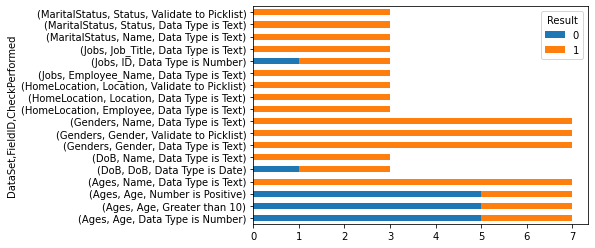

In [94]:
newct.plot(kind='barh', stacked=True)